In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tslearn.piecewise import PiecewiseAggregateApproximation, SymbolicAggregateApproximation

from utils import cargar_dataset, agrupar, generar_random_walk, generar_ruido_blanco

In [2]:
# 1. Cargar datos
df = cargar_dataset(acotar=True)

df.head()

,id,timestamp,provincia,titulo,sentimiento,Hostelería y Turismo,Sanitario y Salud,Educación y Formación,Tecnología y Telecomunicaciones,Construcción e Inmobiliaria,...,Administración y Finanzas,"Cultura, Arte y Ocio",topico_0,topico_1,topico_2,topico_3,topico_4,topico_5,topico_6,topico_7
0,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,Asturias,AGENTE COMERCIAL DE SEGUROS (REF.: 6891),0,0.041404,0.120992,0.041573,0.059019,0.030701,...,0.324229,0.019733,0.026325,0.026326,0.814183,0.026330,0.027860,0.026326,0.026325,0.026325
1,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,Huesca,PERSONAL CONDUCCIÓN DE CAMIONES RÍGIDOS Y GÓND...,0,0.030990,0.057478,0.036322,0.029180,0.147316,...,0.018703,0.017910,0.009713,0.688852,0.009849,0.009813,0.009709,0.252614,0.009740,0.009709
2,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,Las Palmas,EDUCADORES SOCIALES,0,0.091403,0.192666,0.193061,0.050125,0.051813,...,0.115608,0.070124,0.057161,0.332506,0.055559,0.331964,0.055559,0.055561,0.056131,0.055560
3,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,Islas Baleares,PIZZERO (REF. 042025002051),0,0.322015,0.063957,0.053818,0.034641,0.071745,...,0.064199,0.136239,0.595359,0.023262,0.023261,0.134708,0.023259,0.023263,0.153550,0.023339
4,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,Santa Cruz de Tenerife,INTÉRPRETES DE LA LENGUA DE SIGNOS,0,0.080653,0.092984,0.213507,0.103557,0.021882,...,0.032568,0.312488,0.026320,0.026772,0.026344,0.026321,0.026319,0.026320,0.814982,0.026622


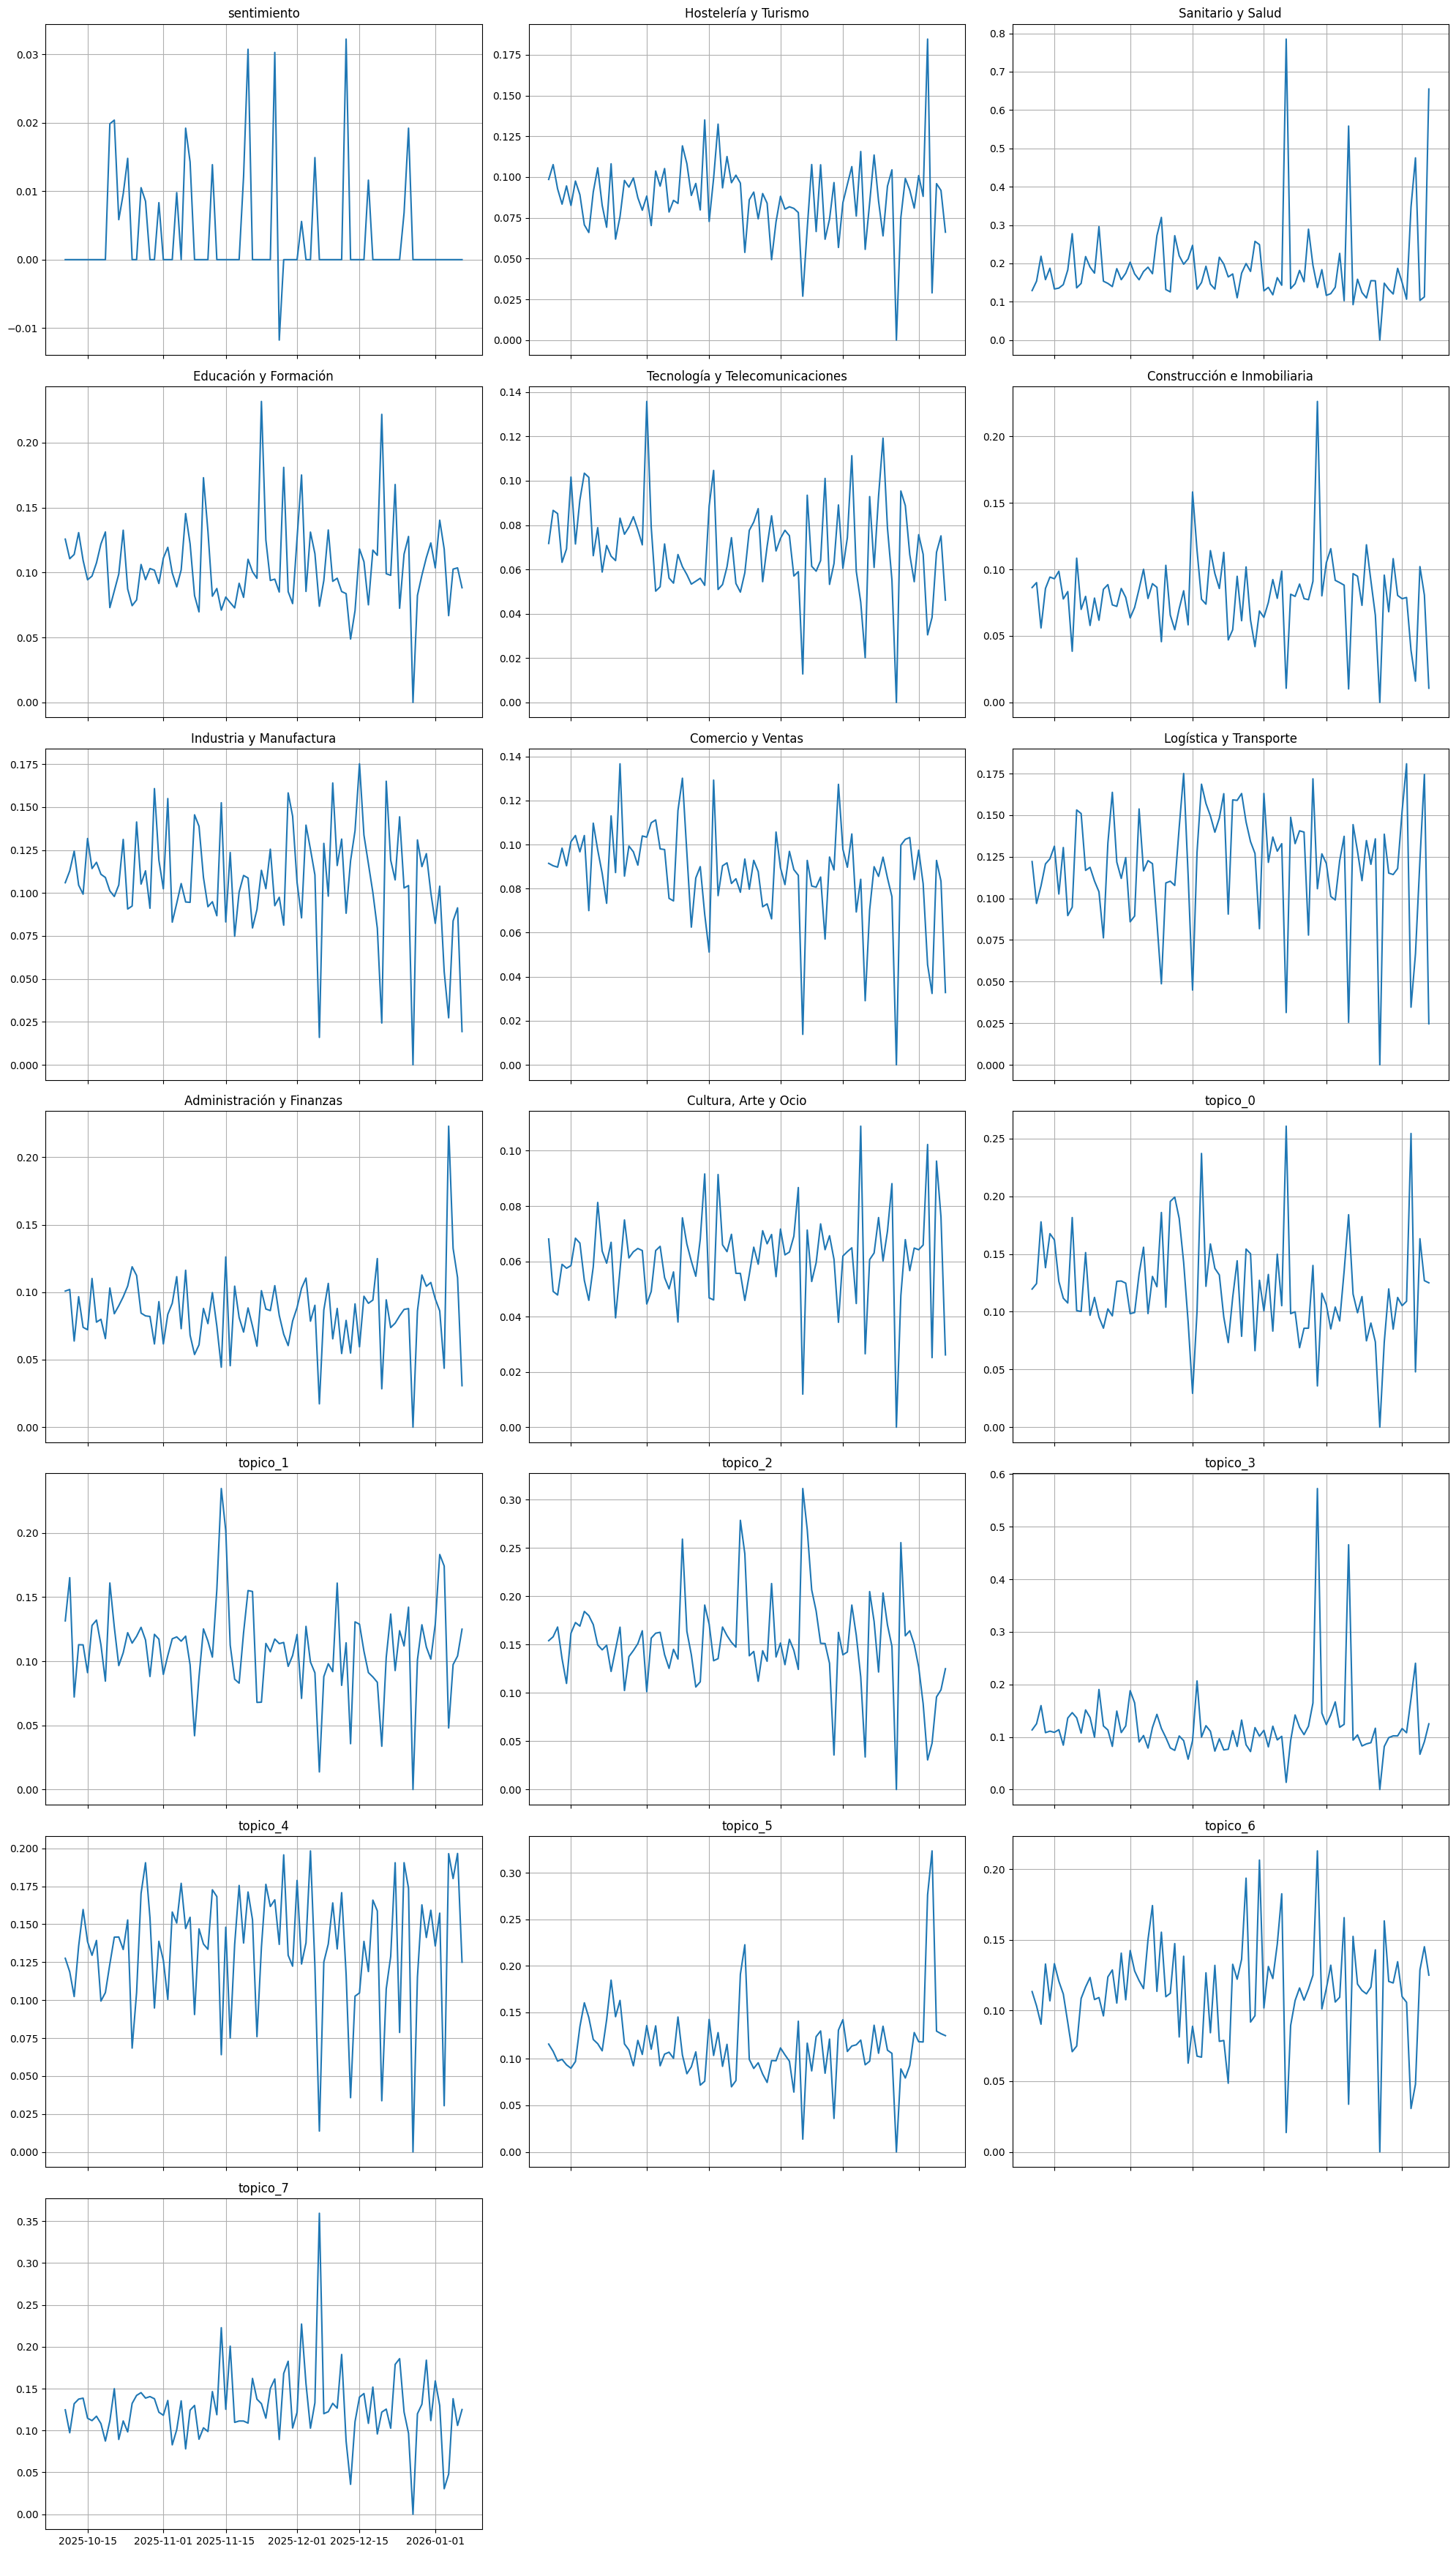

In [3]:
columnas_excluir = ["provincia", "titulo", "id", "timestamp"]
indicadores = [col for col in df.columns if col not in columnas_excluir]

# 3. Configurar subplots: 3 por fila
n_cols = 3
n_rows = int(np.ceil(len(indicadores) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows), sharex=True)
axes = axes.flatten()

# 4. Graficar cada indicador en su subplot
for i, indicador in enumerate(indicadores):
    series_diaria = agrupar(df, indicador, freq="D")
    axes[i].plot(series_diaria.index, series_diaria.values)
    axes[i].set_title(indicador)
    axes[i].grid(True)

# 5. Eliminar subplots vacíos si sobran
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

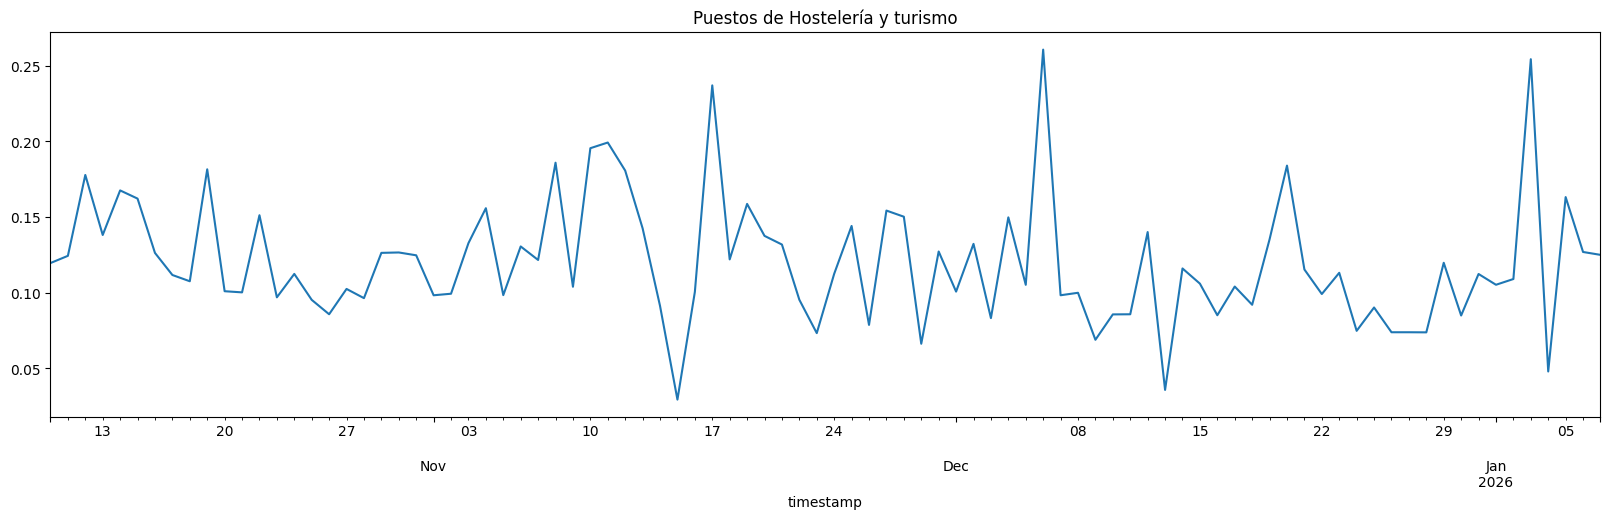

timestamp
2025-10-10    0.119587
2025-10-11    0.124357
2025-10-12    0.177816
2025-10-13    0.138142
2025-10-14    0.167609
Freq: D, Name: topico_0, dtype: float64

In [4]:
indicador = "topico_0"

# 3. Agrupar por días
series_diaria = agrupar(df, indicador, freq="D")
series_diaria = series_diaria.replace(0, np.nan).ffill()

series_diaria.plot(figsize=(20,5), title = "Puestos de Hostelería y turismo")
plt.show()
series_diaria.head()

In [5]:
pd.Series(series_diaria.index).describe()

count                     90
mean     2025-11-23 12:00:00
min      2025-10-10 00:00:00
25%      2025-11-01 06:00:00
50%      2025-11-23 12:00:00
75%      2025-12-15 18:00:00
max      2026-01-07 00:00:00
Name: timestamp, dtype: object

In [6]:
series_diaria.isna().sum()

0

In [7]:
# 4. Test de estacionariedad (ADF)
print("Test ADF sobre la serie:")
adfuller(series_diaria)

Test ADF sobre la serie:


(-9.067006715956293,
 4.4049309305959026e-15,
 0,
 89,
 {'1%': -3.506057133647011,
  '5%': -2.8946066061911946,
  '10%': -2.5844100201994697},
 -262.57126891170424)

Test ADF sobre la random walk:


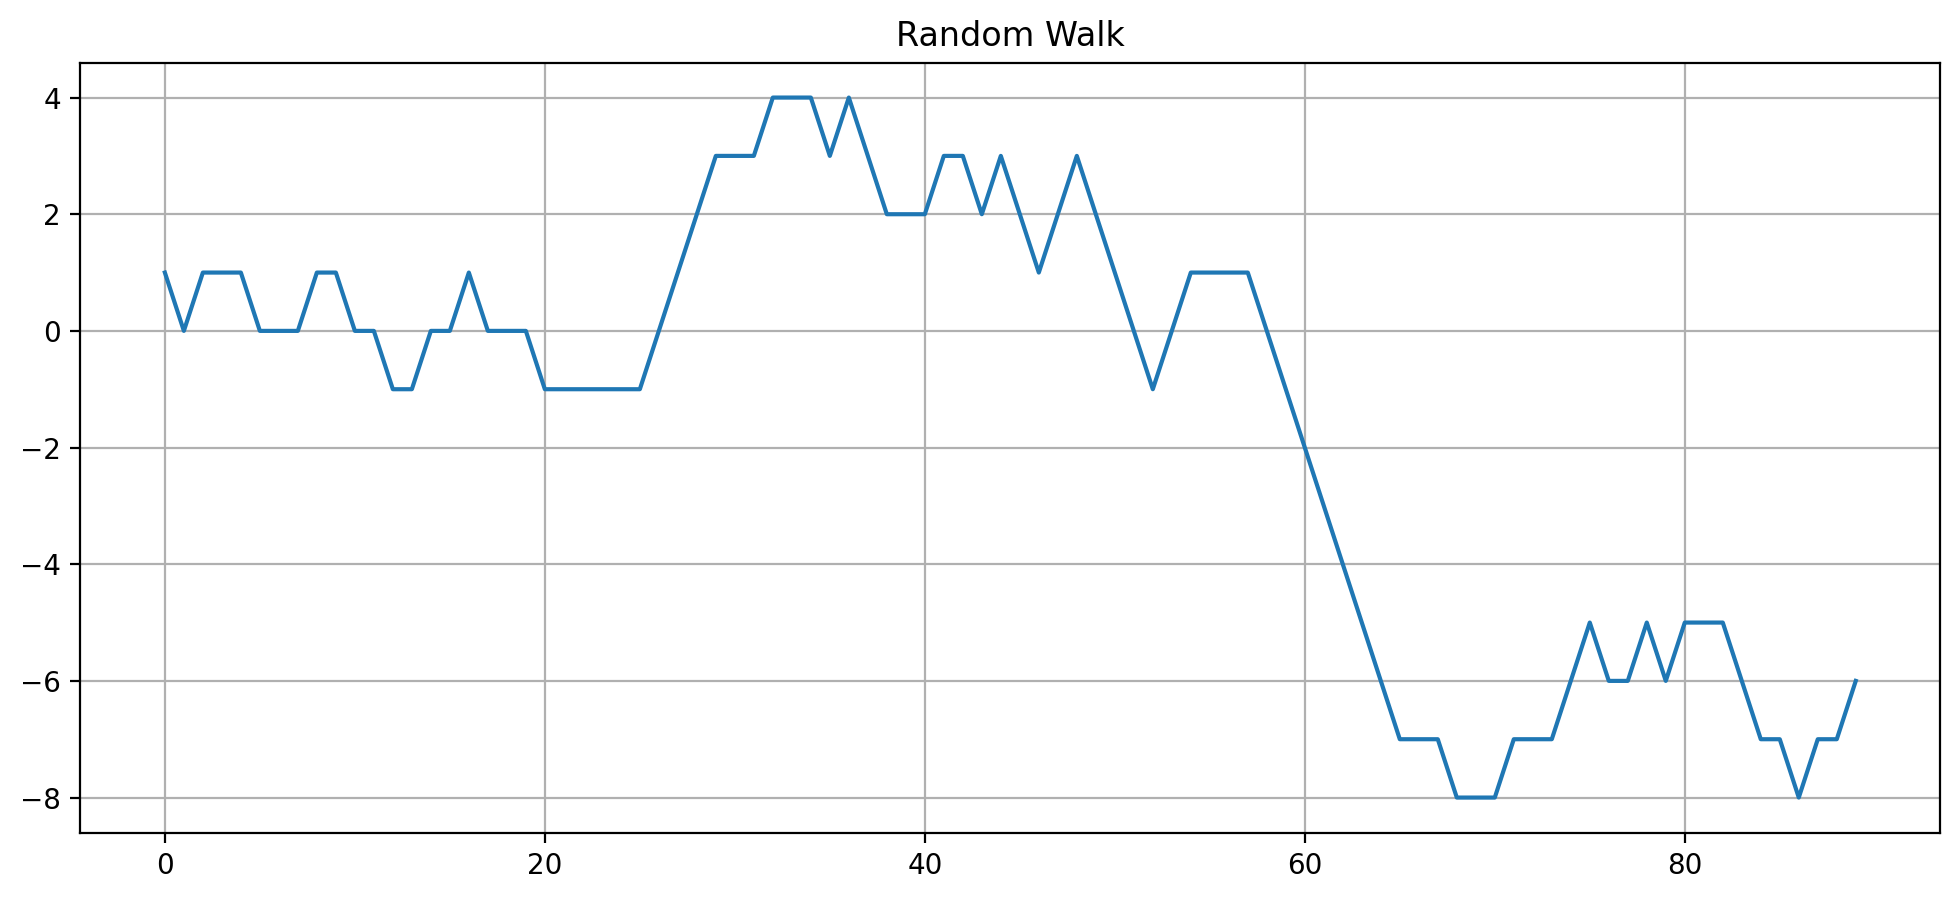

(-0.6708206680569966,
 0.8541635791038569,
 0,
 89,
 {'1%': -3.506057133647011,
  '5%': -2.8946066061911946,
  '10%': -2.5844100201994697},
 183.69751432997626)

In [8]:
print("Test ADF sobre la random walk:")
adfuller(generar_random_walk(step_n=len(series_diaria), plot=True))

Test ADF sobre la random walk:


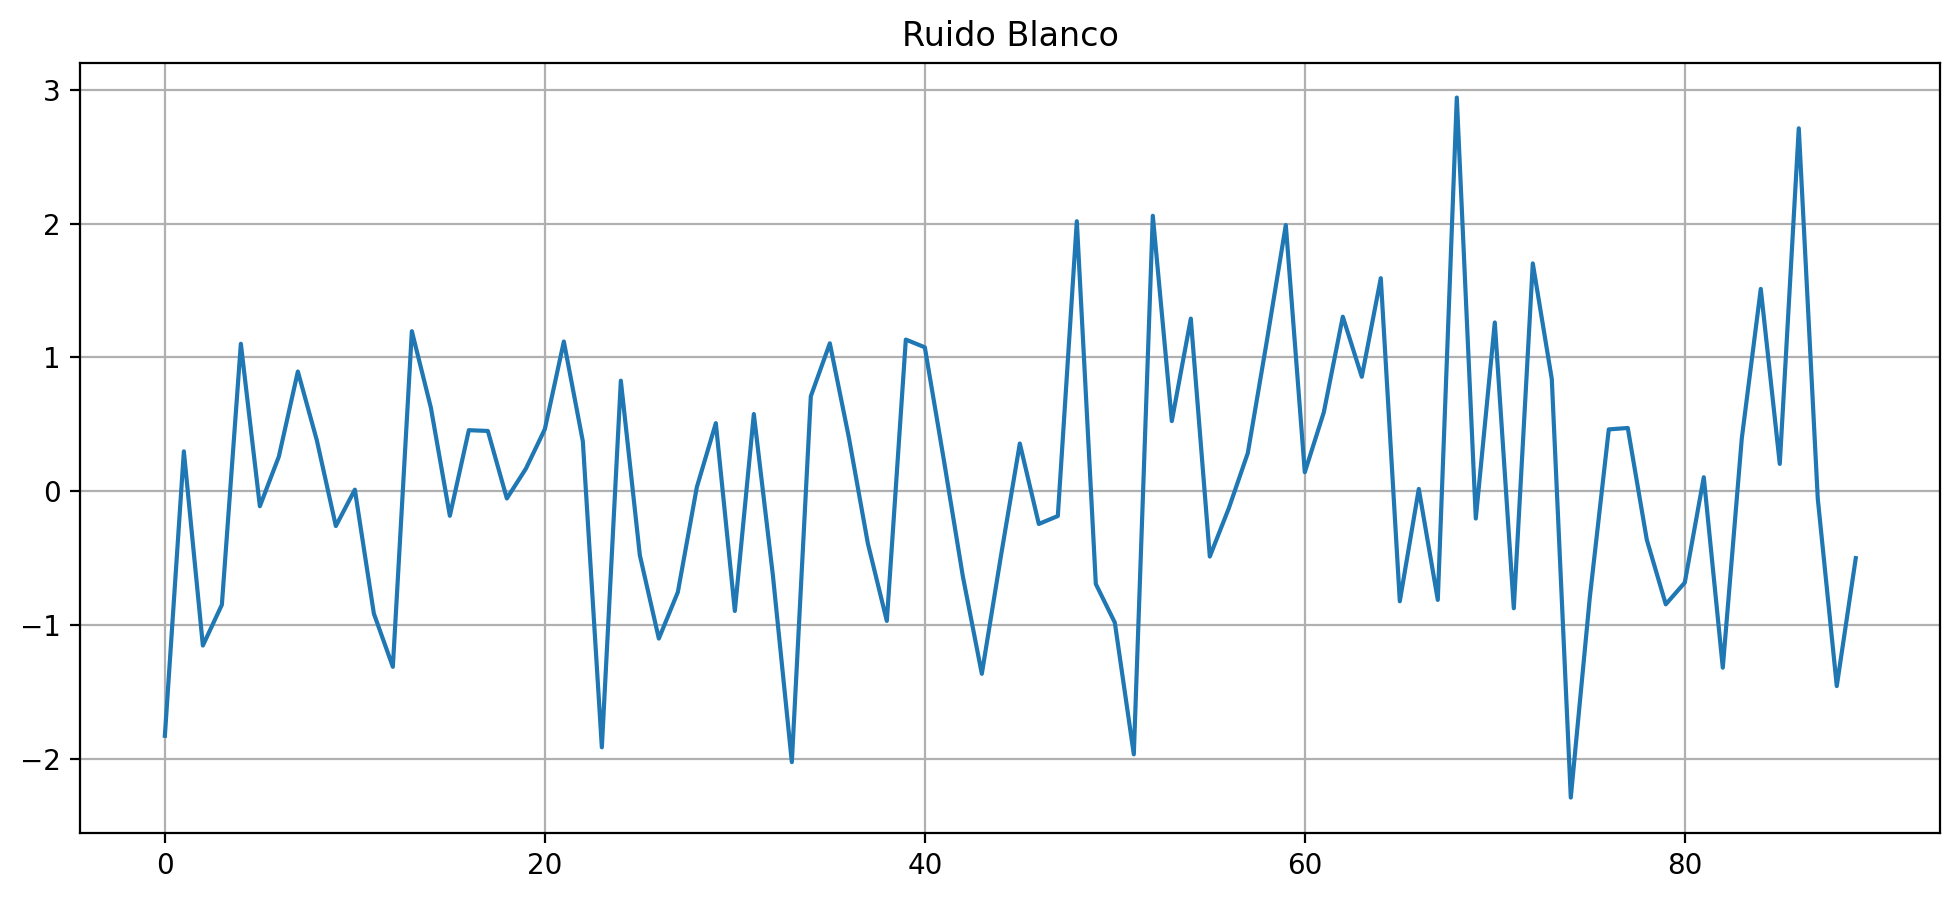

(-9.450532253851154,
 4.629415635899186e-16,
 0,
 89,
 {'1%': -3.506057133647011,
  '5%': -2.8946066061911946,
  '10%': -2.5844100201994697},
 231.84376574908708)

In [9]:
print("Test ADF sobre la random walk:")
adfuller(generar_ruido_blanco(n=len(series_diaria), plot=True))

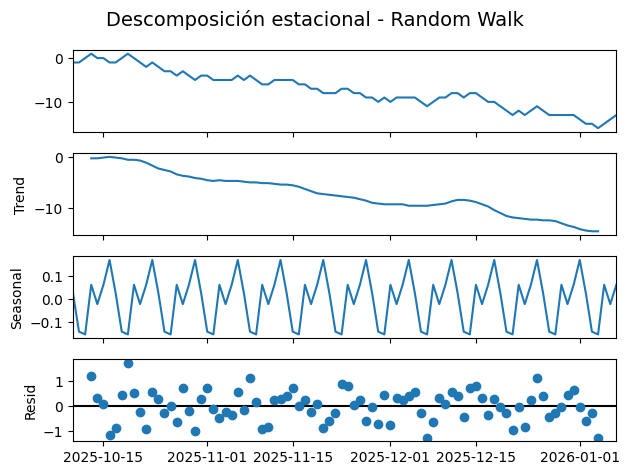

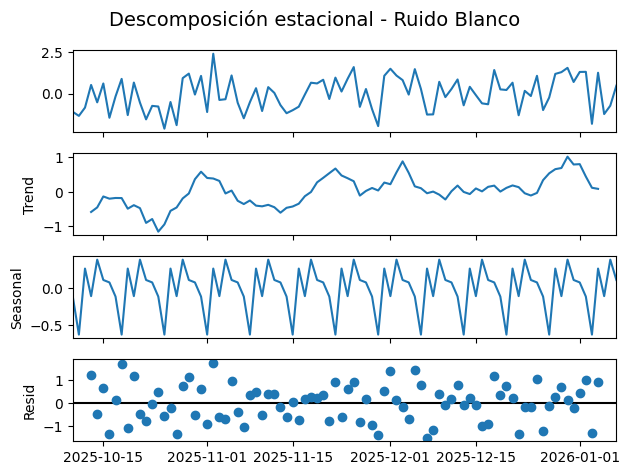

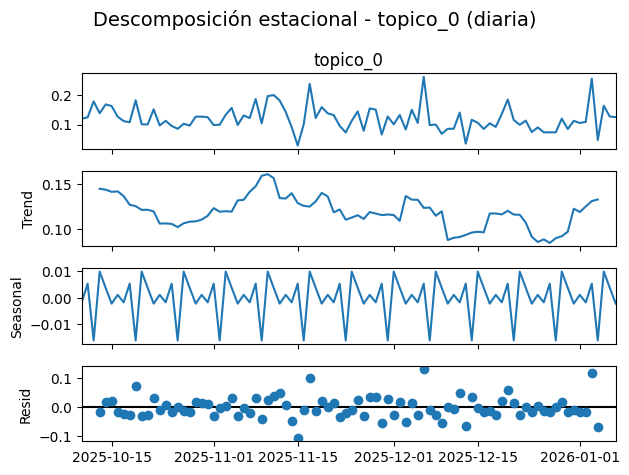

In [10]:
# Random Walk
path_rw = generar_random_walk(step_n=len(series_diaria), plot=False)
series_rw = pd.Series(path_rw, index=series_diaria.index)

# Ruido Blanco
wn = generar_ruido_blanco(n=len(series_diaria), plot=False)
series_wn = pd.Series(wn, index=series_diaria.index)


# --- Descomposición estacional Random Walk ---
result_rw = seasonal_decompose(series_rw, model="additive", period=7)
result_rw.plot()
plt.suptitle("Descomposición estacional - Random Walk", fontsize=14)
plt.tight_layout()
plt.show()

# --- Descomposición estacional Ruido Blanco ---
result_wn = seasonal_decompose(series_wn, model="additive", period=7)
result_wn.plot()
plt.suptitle("Descomposición estacional - Ruido Blanco", fontsize=14)
plt.tight_layout()
plt.show()

# --- Descomposición estacional Serie Real ---
result_real = seasonal_decompose(series_diaria, model="additive", period=7)
result_real.plot()
plt.suptitle(f"Descomposición estacional - {indicador} (diaria)", fontsize=14)
plt.tight_layout()
plt.show()


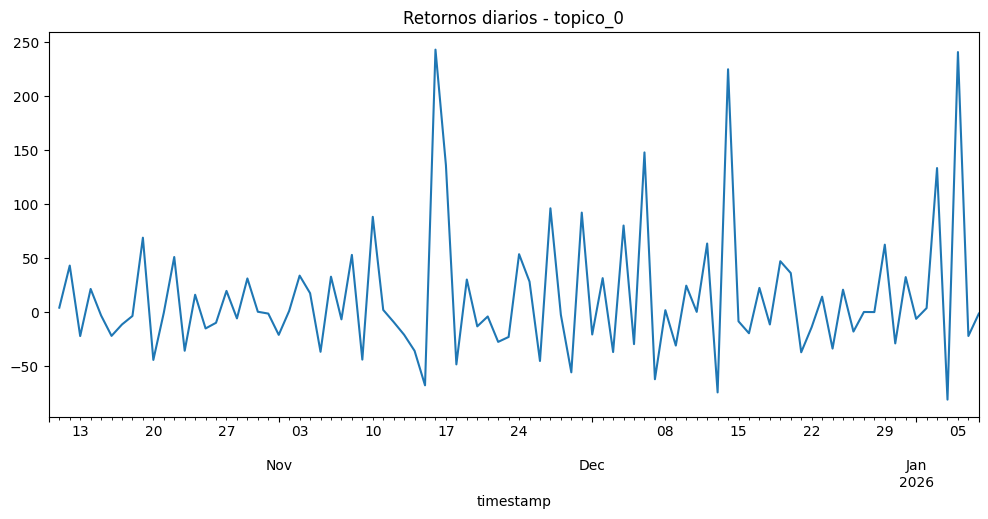

In [11]:
# 6. Retornos (variación porcentual diaria)
returns = series_diaria.pct_change(1) * 100
returns.plot(figsize=(12,5), title=f"Retornos diarios - {indicador}")
plt.show()


In [12]:
print(returns[returns.isna()])
print(returns[returns == np.inf])
returns[returns == np.inf] = 0

timestamp
2025-10-10   NaN
Freq: D, Name: topico_0, dtype: float64
Series([], Freq: D, Name: topico_0, dtype: float64)


In [13]:
print("Test ADF sobre retornos:")
adfuller(returns[1:])


Test ADF sobre retornos:


(-13.436305059690582,
 3.923624164307445e-25,
 0,
 88,
 {'1%': -3.506944401824286,
  '5%': -2.894989819214876,
  '10%': -2.584614550619835},
 841.8456060040713)

/home/miguel/python3.12/lib/python3.12/site-packages/tslearn/utils/utils.py:129: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn(
/home/miguel/python3.12/lib/python3.12/site-packages/tslearn/utils/utils.py:129: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn(


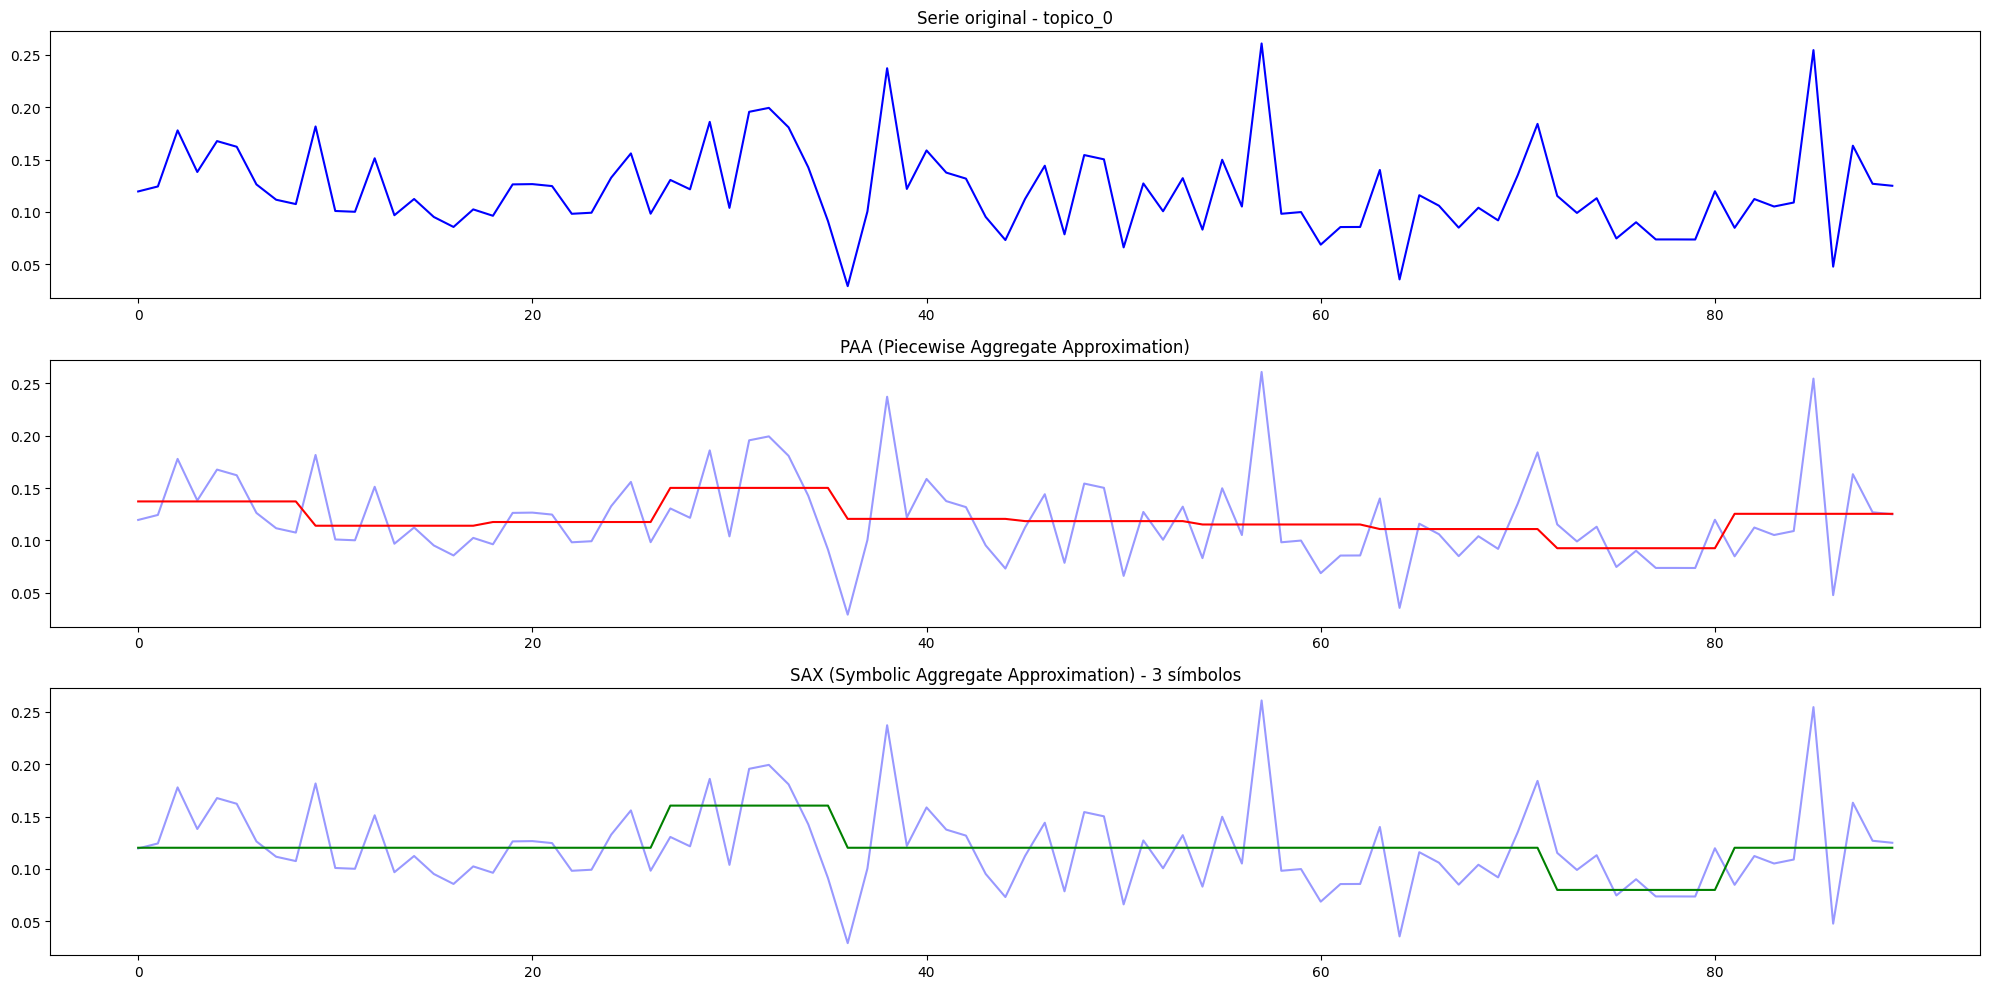

In [14]:
# 7. Reducción de complejidad con PAA y SAX
raeashape = np.array(series_diaria.tolist()).reshape(1, -1)

# PAA
n_paa_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
paa_inv = paa.inverse_transform(paa.fit_transform(raeashape))

# Normalización para SAX
data_norm = (raeashape - np.mean(raeashape)) / np.std(raeashape)

# SAX
n_sax_symbols = 3
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
sax_inv = sax.inverse_transform(sax.fit_transform(data_norm))
sax_inv_desnorm = (sax_inv * np.std(raeashape)) + np.mean(raeashape)

# 8. Graficar original vs PAA vs SAX
plt.figure(figsize=(20,10))

plt.subplot(3, 1, 1)
plt.plot(series_diaria.values, "b-")
plt.title(f"Serie original - {indicador}")

plt.subplot(3, 1, 2)
plt.plot(series_diaria.values, "b-", alpha=0.4)
plt.plot(paa_inv[0].ravel(), "r-")
plt.title("PAA (Piecewise Aggregate Approximation)")

plt.subplot(3, 1, 3)
plt.plot(series_diaria.values, "b-", alpha=0.4)
plt.plot(sax_inv_desnorm[0].ravel(), "g-")
plt.title(f"SAX (Symbolic Aggregate Approximation) - {n_sax_symbols} símbolos")

plt.tight_layout()
plt.show()


# Holt-Winters

Las técnicas de pronóstico exponencial permiten obtener aproximaciones de las series de tiempo de una manera sencialla y con buenos resultados para series no estacionarias. Esta tecnica se basa calcular cada observacion basandose en las observaciones anteriores dando un menor peso a las observaciones mas antiguas y mayor a las mas cercanas. Estas técnicas también son conocidas como técnicas de suavizado exponencial.

El proceso mas simple es el de **promedios móviles ponderados exponencialmente (EWMA)** que es equivalente a un **Suavizado exponencial simple** usando un solo factor de suavizado  **α  (alpha)** [0..1] y que no tiene en cuenta otros factores como la tendencia o la estacionalidad. Aunque esta tecnica es buena para observar graficamente la tendencia es desaconsejada para predecir nuevas observaciones mas alla de una observacion en el futuro.

En el **Suavizado exponencial doble** (también conocido como *Método de Holt*) aparece ya un factor **β (beta)** que aborda la tendencia de la serie y que permite predecir con un factor acumulativo o multiplicativo de las series la tendencia.

Con **Suavizado exponencial triple** (también conocido como *Método Holt-Winters*) presentamos un factor de suavizado  **γ  (gamma)** que representa la estacionalidad de la serie.

Los valores de **α  (alpha)**, **β (beta)**, **γ  (gamma)** mas cercanos a 1 dan mas peso a las observaciones recientes frente a las pasadas, mientras que valores cercanos a 0 acercan la predicion a la media de  los valores anteriores.

In [15]:
# Calcular el índice de división
train_size = int(len(series_diaria) * 0.9)  # 90% para entrenamiento
work_data_train = series_diaria.iloc[:train_size]   # Conjunto de entrenamiento
work_data_test = series_diaria.iloc[train_size:]     # Conjunto de prueba

work_data_train = pd.DataFrame(work_data_train)
work_data_test = pd.DataFrame(work_data_test)

# Suavizado exponencial simple


In [16]:
# Factor alfa que no es obligatorio, se puede calcular de manera inversa y el span representa "algo parecido" a la estacionalidad.
span = 7
alpha = 2/(span+1)

# EWMA
work_data_train['EWMA_12'] = work_data_train[series_diaria.name].ewm(alpha=alpha, adjust=False).mean()

# SES automático 
autoSES = SimpleExpSmoothing(work_data_train[series_diaria.name]).fit()
work_data_train['SES'] = autoSES.fittedvalues
print("SES Calculated Smoothed: " + str(autoSES.params['smoothing_level']))

# SES con smoothing_level fijo
work_data_train['SES_12'] = SimpleExpSmoothing(work_data_train[series_diaria.name])\
    .fit(smoothing_level=alpha, optimized=False).fittedvalues.shift(-1)

# Ver primeras filas
work_data_train.head()

SES Calculated Smoothed: 1.4901161193847656e-08


,topico_0,EWMA_12,SES,SES_12
timestamp,,,,
2025-10-10,0.119587,0.119587,0.119587,0.119587
2025-10-11,0.124357,0.120779,0.119587,0.120779
2025-10-12,0.177816,0.135039,0.119587,0.135039
2025-10-13,0.138142,0.135814,0.119587,0.135814
2025-10-14,0.167609,0.143763,0.119587,0.143763


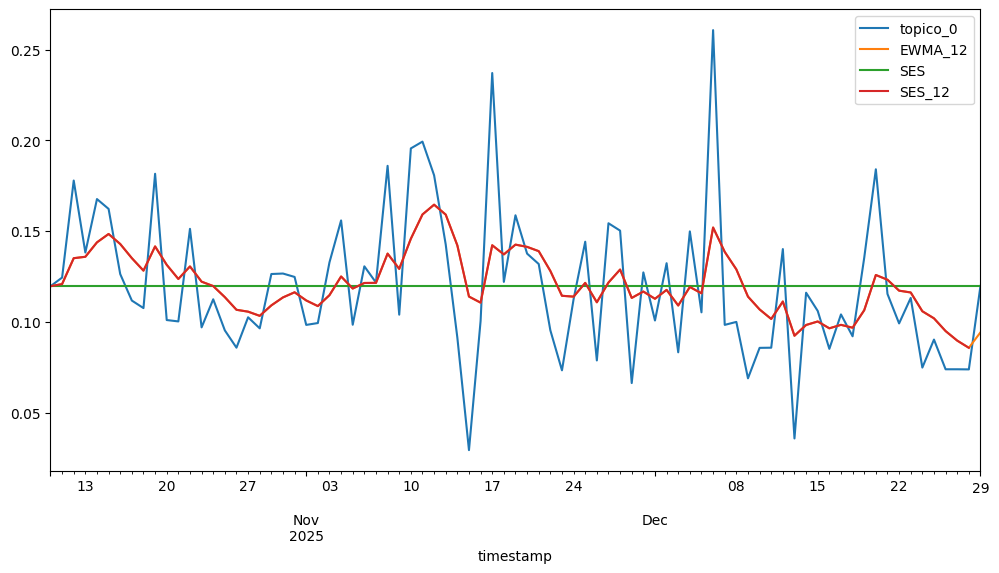

In [17]:
work_data_train[[indicador,'EWMA_12','SES','SES_12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

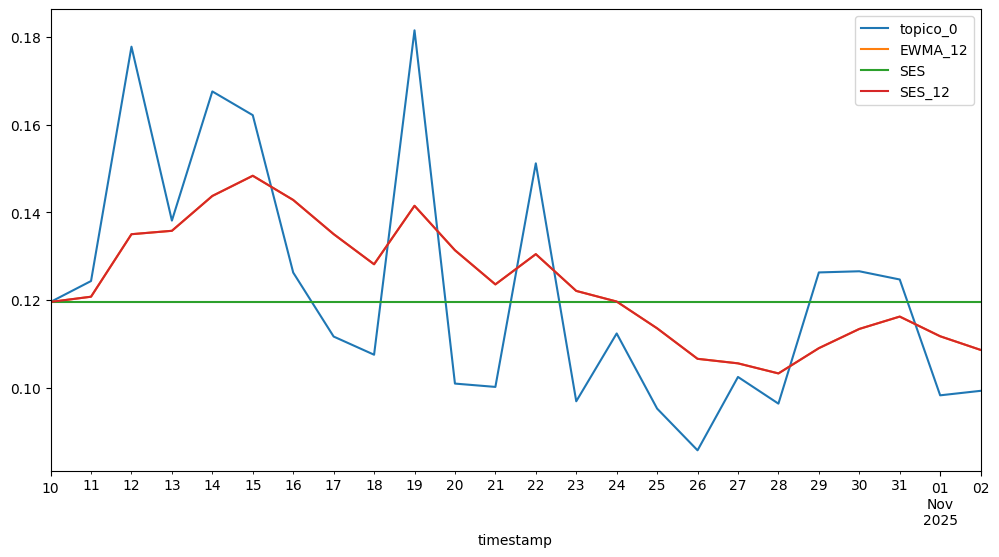

In [18]:
work_data_train[[indicador,'EWMA_12','SES','SES_12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

# Suavizado exponencial doble
Este modelo tiene como entrada dos tipos de crecimiento, un crecimiento **aditivo**, para series que asemejan a un crecimiento lineal y **multiplicativo** para series que asemejan un crecimiento exponencial.


In [19]:
series_diaria[series_diaria == 0] 

Series([], Freq: D, Name: topico_0, dtype: float64)

In [20]:
work_data_train['DESadd'] = ExponentialSmoothing(work_data_train[indicador], trend = 'add').fit().fittedvalues.shift(-1)
work_data_train['DESmul'] = ExponentialSmoothing(work_data_train[indicador], trend = 'mul').fit().fittedvalues.shift(-1) #No se puede si hay un cero

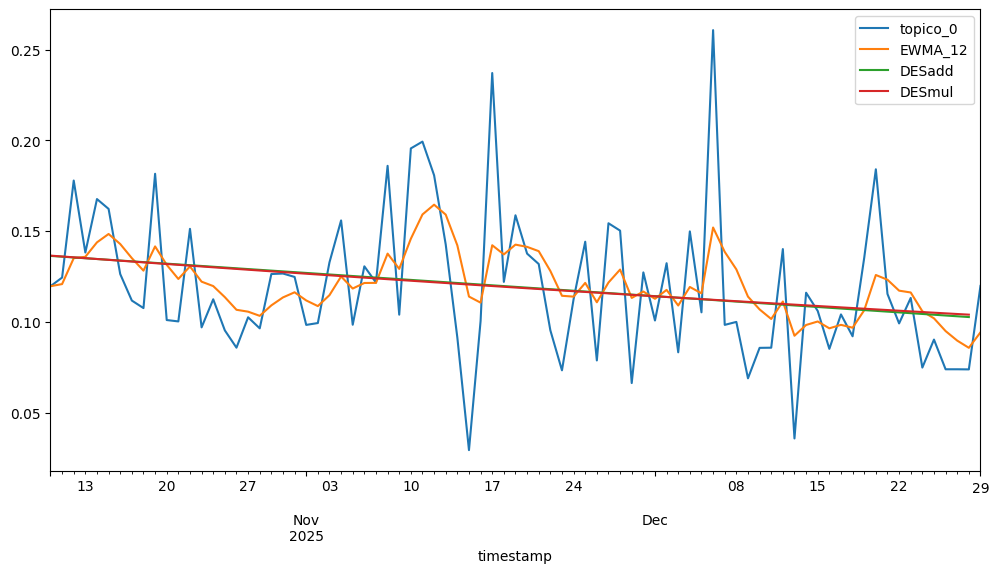

In [21]:
work_data_train[[indicador,'EWMA_12','DESadd', 'DESmul']].plot(figsize=(12,6)).autoscale(axis='x',tight=True) 

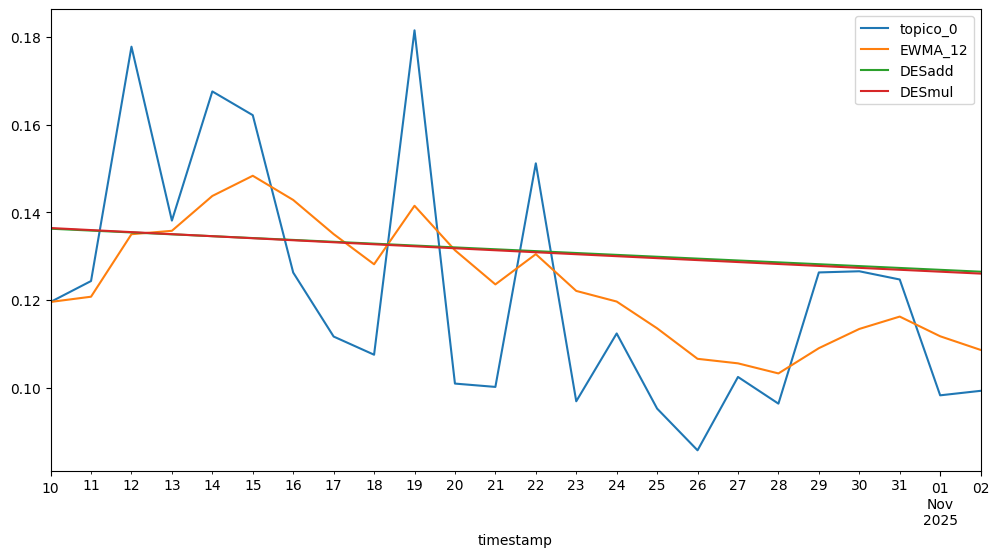

In [22]:
work_data_train[[indicador,'EWMA_12','DESadd','DESmul']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

# Suavizado exponencial triple
Suavizado exponencial triple o *Holt-Winters*, inclye tambien la estacionalida que tambien puede ser de tipo **acumulativo** o **exponencial**.



In [23]:
work_data_train['TESaddadd12'] = ExponentialSmoothing(work_data_train[indicador],trend='add',seasonal='add',seasonal_periods=7).fit().fittedvalues
work_data_train['TESaddmul12'] = ExponentialSmoothing(work_data_train[indicador],trend='add',seasonal='mul',seasonal_periods=7).fit().fittedvalues
work_data_train['TESmuladd12'] = ExponentialSmoothing(work_data_train[indicador],trend='mul',seasonal='add',seasonal_periods=7).fit().fittedvalues
work_data_train['TESmulmul12'] = ExponentialSmoothing(work_data_train[indicador],trend='mul',seasonal='mul',seasonal_periods=7).fit().fittedvalues


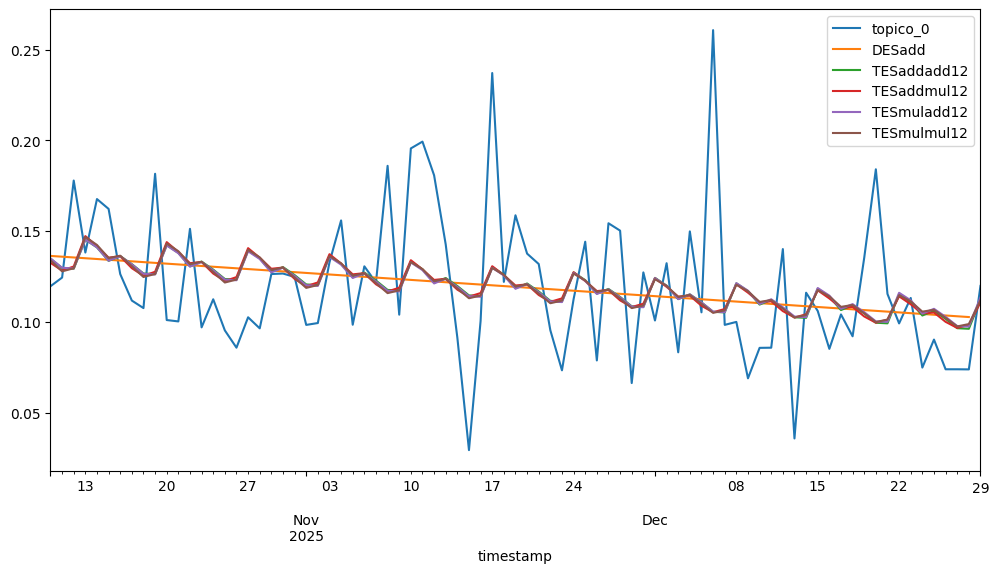

In [24]:
work_data_train[[indicador,'DESadd','TESaddadd12','TESaddmul12','TESmuladd12','TESmulmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

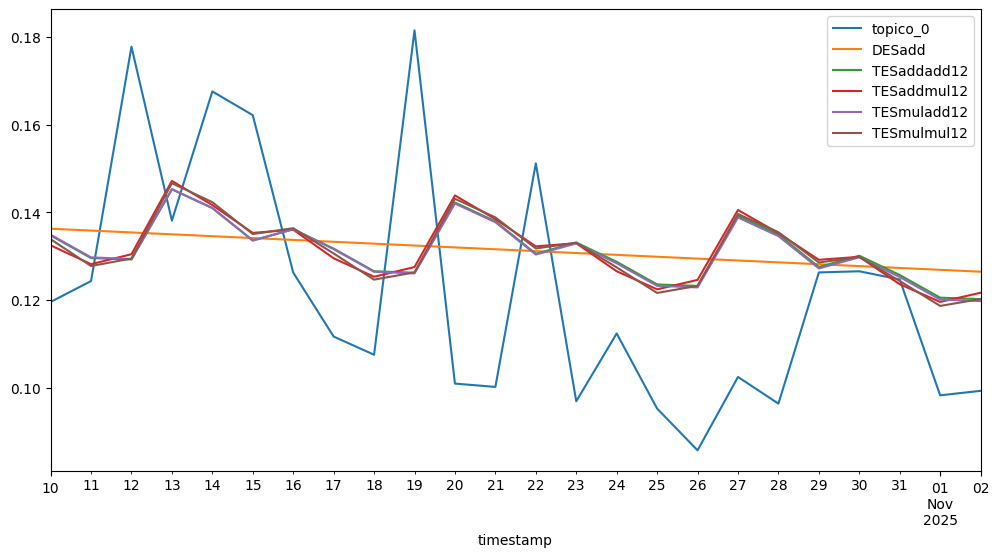

In [25]:
work_data_train[[indicador,'DESadd','TESaddadd12','TESaddmul12','TESmuladd12','TESmulmul12']].iloc[:24].plot(figsize=(12,6));

In [26]:
model_add_add = ExponentialSmoothing(work_data_train[indicador],trend='add',seasonal='add',seasonal_periods=7).fit()
model_add_mul = ExponentialSmoothing(work_data_train[indicador],trend='add',seasonal='mul',seasonal_periods=7).fit()
model_mul_add = ExponentialSmoothing(work_data_train[indicador],trend='mul',seasonal='add',seasonal_periods=7).fit()
model_mul_mul = ExponentialSmoothing(work_data_train[indicador],trend='mul',seasonal='mul',seasonal_periods=7).fit()
model_add = ExponentialSmoothing(work_data_train[indicador], trend = 'add').fit()
model_ = SimpleExpSmoothing(work_data_train[indicador]).fit(smoothing_level=alpha,optimized=False)

In [27]:
n = len(work_data_test) + 1
forecast_add_add = model_add_add.forecast(n)
forecast_add_mul = model_add_mul.forecast(n)
forecast_mul_add= model_mul_add.forecast(n)
forecast_mul_mul= model_mul_mul.forecast(n)
forecast_add= model_add.forecast(n)
forecast_= model_.forecast(n)

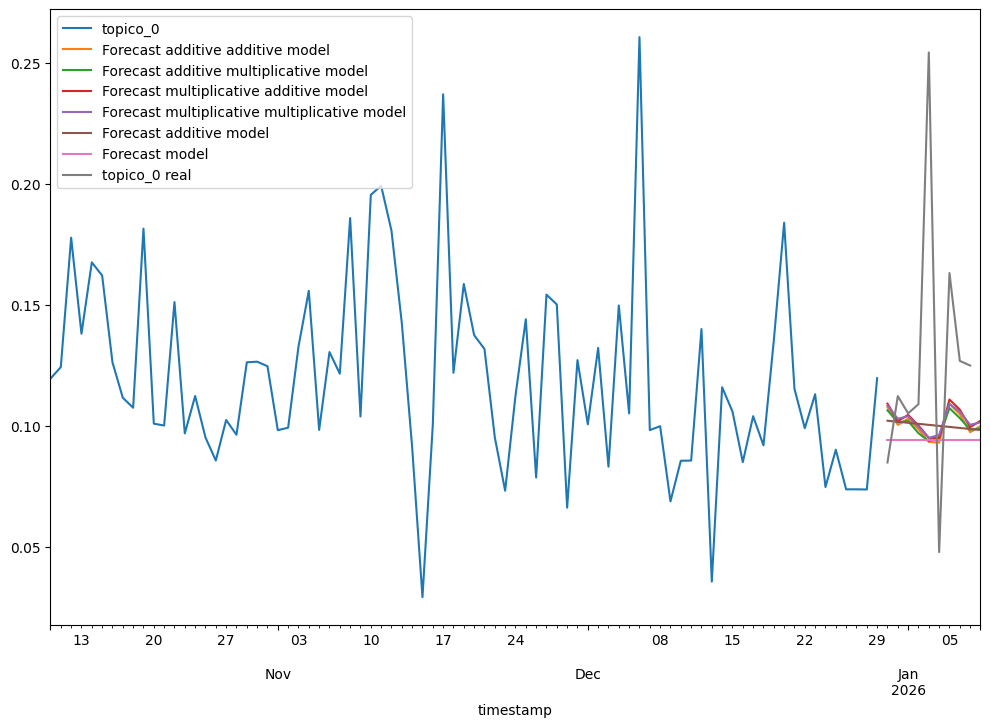

In [28]:
work_data_train[indicador].plot(figsize=(12,8))
forecast_add_add.plot(label='Forecast additive additive model');
forecast_add_mul.plot(label='Forecast additive multiplicative model');
forecast_mul_add.plot(label='Forecast multiplicative additive model');
forecast_mul_mul.plot(label='Forecast multiplicative multiplicative model');
forecast_add.plot(label='Forecast additive model');
forecast_.plot(label='Forecast model');
work_data_test[indicador].plot(label=f'{indicador} real')
plt.legend(loc='upper left')

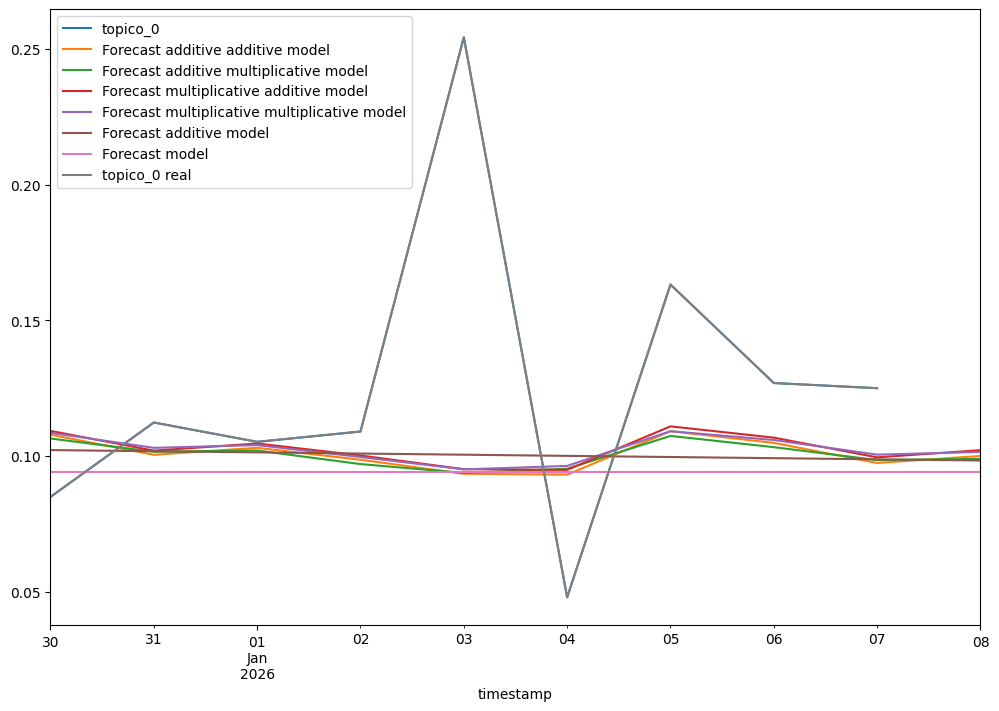

In [29]:
series_diaria.iloc[len(work_data_train):].plot(figsize=(12,8))
forecast_add_add.plot(label='Forecast additive additive model');
forecast_add_mul.plot(label='Forecast additive multiplicative model');
forecast_mul_add.plot(label='Forecast multiplicative additive model');
forecast_mul_mul.plot(label='Forecast multiplicative multiplicative model');
forecast_add.plot(label='Forecast additive model');
forecast_.plot(label='Forecast model');
work_data_test[indicador].plot(label=f'{indicador} real')
plt.legend(loc='upper left')